# Quantum Ising Variational Classifier: Bars-and-Stripes data set

Version 10/09/2024

This is a tutorial based on PennyLane demo by Maria Schuld at https://pennylane.ai/qml/demos/tutorial_variational_classifier/.

In this notebook we study the performance of the Quantum Variational Classifier on detecting whether a picture is in the BAS dataset. We will use a variational circuit based on Ising quantum gates.


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import matplotlib.pyplot as plt

## The Bars-and-Stripes (BAS) data set

Bars-and-Stripes are $n \times n$ pixel pictures. Each pixel can be black or white. The picture belongs to the BAS dataset if its formed by bars or stripes.

First we use a function that creates the BAS data set (actually we take from here: https://pennylane.ai/qml/demos/tutorial_qcbm/)

In [ ]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


n = 2
size = n**2
data = get_bars_and_stripes(n)
print(data.shape)

(6, 4)


In [ ]:
def generate_data_BAS(m):
    # n = number of qubits
    # returns data = matrix with first n columns storing the bits and the last column whether belongs ('1') or not ('0') to BAS
    BAS = get_bars_and_stripes(m)
    n = m*m
    data = np.zeros([2**n,n+1],dtype = int)
    Ndata = int(2**n)
    for j in range(0,Ndata):
        jbin = np.array(list(bin(j)[2:].zfill(n)),dtype=int)
        data[j,0:-1] = jbin
        data[j,-1] = int(np.min(np.sum((jbin - BAS)**2,1))==0)
    return data

In [ ]:
all_data = generate_data_BAS(2)
all_data.shape

(16, 5)

In [ ]:
dev = qml.device("default.qubit")

Our variational circuit's layer is going to be composed of a series of X-Rotations, Y-Rotations, and Ising gates. We still encapsulate all these parameters in the array `weights`.

The Ising gates act on all possible pairs of sites:

$$
U_{j,k} = e^{i \theta_{j,k} Z_j Z_k}
$$

In [ ]:
def layer_Ising(layer_weights,n):
    # n is the number of qubits
    X_angles = layer_weights[0:n]
    Y_angles = layer_weights[n:2*n]
    Ising_angles = layer_weights[2*n:2*n + int(n*(n-1)/2)]
    for wire in range(n):
        qml.RX(X_angles[wire],wire)
    count = 0
    for wirex in range(0,n):
        for wirey in range(wirex+1,n):
            #print(wirex*(n-1) + (wirey-wirex-1))
            qml.IsingZZ(Ising_angles[count],wires = [wirex,wirey])
            count = count + 1
    for wire in range(n):
        qml.RY(Y_angles[wire],wire)

We also need a way to encode data inputs $x$ into the circuit, so that
the measured output depends on the inputs. In this first example, the
inputs are bitstrings, which we encode into the state of the qubits. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

The `~pennylane.BasisState`{.interpreted-text role="class"} function
provided by PennyLane is made to do just this. It expects `x` to be a
list of zeros and ones, i.e. `[0,1,0,1]`.


In [ ]:
def state_preparation(x):
    qml.BasisState(x, wires=range(0,len(x)))

Now we define the variational quantum circuit as this state preparation
routine, followed by a repetition of the layer structure.


In [ ]:
@qml.qnode(dev)

def circuit_Ising(weights, x, n):
    state_preparation(x)
    for layer_weights in weights:
        layer_Ising(layer_weights,n)

    return qml.expval(qml.PauliZ(0))

If we want to add a "classical" bias parameter, the variational quantum
classifier also needs some post-processing. We define the full model as
a sum of the output of the quantum circuit, plus the trainable bias.


In [ ]:
def variational_classifier(weights, bias, x):
    return circuit_Ising(weights, x, len(x)) + bias

## Defininig the cost function

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We restrict ourselves to the standard square
loss that measures the distance between target labels and model
predictions.


In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy, or the proportion of predictions that agree
with a set of target labels.


In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## Optimization

We divide the total date into a training set and test set. We will train the algorithm by using the training set and then we will see how much it is able to generalize by testing it with the testing set. For simplicity, we choose half of the data for each of the sets.

In [ ]:
from sklearn.model_selection import train_test_split
[training_data, test_data] = train_test_split(all_data,train_size= int(len(all_data)/1.4))
print(f'size of the training_data = {len(training_data)}')
print(f'size of the test_data = {len(test_data)}')

size of the training_data = 11
size of the test_data = 5


In [ ]:
X = np.array(training_data[:, :-1])
Y = np.array(training_data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}
#for x,y in zip(X, Y):
#    print(f"x = {x}, y = {y}")

We initialize the variables randomly (but fix a seed for reproducibility). Remember that one of the variables is used as a bias,
while the rest is fed into the gates of the variational circuit.

In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 1
# length of layer_weights vector
L = int(2*num_qubits + num_qubits*(num_qubits-1)/2)
weights_init = 0.01 * np.random.randn(num_layers, L , requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[ 0.01764052  0.00400157  0.00978738  0.02240893  0.01867558 -0.00977278
   0.00950088 -0.00151357 -0.00103219  0.00410599  0.00144044  0.01454274
   0.00761038  0.00121675]]
Bias:  0.0


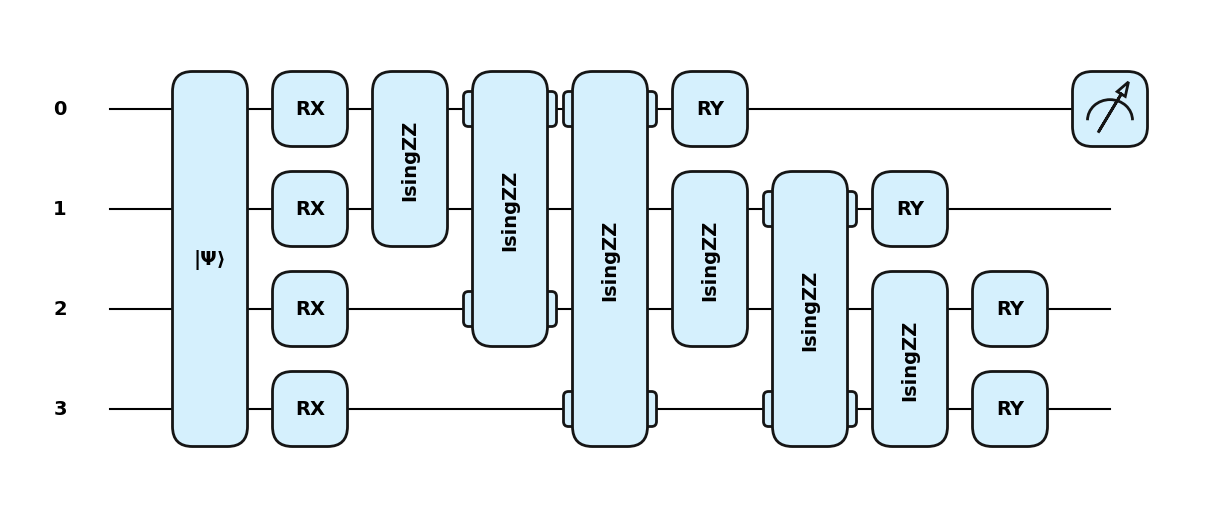

In [ ]:
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(circuit_Ising)(weights_init,[0,0,0,0],num_qubits)


In [ ]:
opt = qml.NesterovMomentumOptimizer(0.1,.4)
batch_size = int(len(training_data))
print(f"batch size is {batch_size}")

batch size is 11


...and run the optimizer to train our model. We track the accuracy - the
share of correctly classified data samples. For this we compute the
outputs of the variational classifier and turn them into predictions in
$\{-1,1\}$ by taking the sign of the output.


In [ ]:
weights = weights_init
bias = bias_init
for it in range(200):
    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy (note that for the predictions we "discretize" the output!!)
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    #print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.1821346 | Accuracy: 0.4545455
Iter:    2 | Cost: 2.1802547 | Accuracy: 0.4545455
Iter:    3 | Cost: 2.1834275 | Accuracy: 0.4545455
Iter:    4 | Cost: 2.1821379 | Accuracy: 0.4545455
Iter:    5 | Cost: 2.1832945 | Accuracy: 0.4545455
Iter:    6 | Cost: 2.2819589 | Accuracy: 0.4545455
Iter:    7 | Cost: 2.2019546 | Accuracy: 0.4545455
Iter:    8 | Cost: 2.1169711 | Accuracy: 0.4545455
Iter:    9 | Cost: 2.0633019 | Accuracy: 0.4545455
Iter:   10 | Cost: 2.0372448 | Accuracy: 0.4545455
Iter:   11 | Cost: 1.8590253 | Accuracy: 0.4545455
Iter:   12 | Cost: 1.7785963 | Accuracy: 0.4545455
Iter:   13 | Cost: 1.6495685 | Accuracy: 0.4545455
Iter:   14 | Cost: 1.4141735 | Accuracy: 0.4545455
Iter:   15 | Cost: 1.2141408 | Accuracy: 0.4545455
Iter:   16 | Cost: 1.1134067 | Accuracy: 0.4545455
Iter:   17 | Cost: 1.0283137 | Accuracy: 0.4545455
Iter:   18 | Cost: 0.9744132 | Accuracy: 0.4545455
Iter:   19 | Cost: 0.9445752 | Accuracy: 0.5454545
Iter:   20 | Cost: 0.9574609 | 

Iter:  163 | Cost: 0.2621107 | Accuracy: 1.0000000
Iter:  164 | Cost: 0.2615301 | Accuracy: 1.0000000
Iter:  165 | Cost: 0.2663627 | Accuracy: 1.0000000
Iter:  166 | Cost: 0.2692677 | Accuracy: 1.0000000
Iter:  167 | Cost: 0.2959813 | Accuracy: 1.0000000
Iter:  168 | Cost: 0.2985619 | Accuracy: 1.0000000
Iter:  169 | Cost: 0.2900570 | Accuracy: 1.0000000
Iter:  170 | Cost: 0.2702463 | Accuracy: 1.0000000
Iter:  171 | Cost: 0.2639959 | Accuracy: 1.0000000
Iter:  172 | Cost: 0.2817038 | Accuracy: 1.0000000
Iter:  173 | Cost: 0.2796834 | Accuracy: 1.0000000
Iter:  174 | Cost: 0.2798636 | Accuracy: 1.0000000
Iter:  175 | Cost: 0.2688016 | Accuracy: 1.0000000
Iter:  176 | Cost: 0.2665658 | Accuracy: 1.0000000
Iter:  177 | Cost: 0.2655265 | Accuracy: 1.0000000
Iter:  178 | Cost: 0.2630629 | Accuracy: 1.0000000
Iter:  179 | Cost: 0.2647429 | Accuracy: 1.0000000
Iter:  180 | Cost: 0.2762554 | Accuracy: 1.0000000
Iter:  181 | Cost: 0.2811936 | Accuracy: 1.0000000
Iter:  182 | Cost: 0.2797089 | 

As we can see, the variational classifier learned to classify all bit strings from the training set correctly.

Actually the agreement is too good, which means there is a depth 2 circuit that is capable of imprinting the parity on the first qubit just exactly - however we did not have to worry about programming it, the varational algorithm finds it automatically!

Our goal is to generalize from limited data to *unseen* examples. Even if the variational quantum circuit was perfectly optimized with respect to the cost, it might not generalize, a phenomenon known as *overfitting*.

Let us check now how good our variational algorithm is in predicting the parity of the data in the test set.

In [ ]:
X_test = np.array(test_data[:, :-1])
Y_test = np.array(test_data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [1 1 0 1], y = -1, pred=-1.0
x = [0 1 1 1], y = -1, pred=-1.0
x = [0 0 1 0], y = -1, pred=-1.0
x = [0 0 0 0], y = 1, pred=1.0
x = [1 0 1 1], y = -1, pred=-1.0
Accuracy on unseen data: 1.0


Amazing!! The algorithm works very well on unseen data, which is actually quite remarkable...

Let us do now some statistics to check whether this was just luck, or the program actually works

In [ ]:
ntrials = 10
acc_vec = np.zeros(10)
#
for j in range(0,ntrials):
    [training_data, test_data] = train_test_split(all_data,train_size= int(len(all_data)/1.4))
    X = np.array(training_data[:, :-1])
    Y = np.array(training_data[:, -1])
    Y = Y * 2 - 1
    np.random.seed(0)
    num_qubits = 4
    num_layers = 1
    # length of layer_weights vector
    L = int(2*num_qubits + num_qubits*(num_qubits-1)/2)
    weights_init = 0.01 * np.random.randn(num_layers, L , requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(0.2,.5)
    batch_size = int(len(training_data))
 #   print(f"batch size is {batch_size}")
    weights = weights_init
    bias = bias_init
    for it in range(100):
        # Update the weights by one optimizer step, using only a limited batch of data
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

        # Compute accuracy (note that for the predictions we "discretize" the output!!)
        predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

        current_cost = cost(weights, bias, X, Y)
        acc = accuracy(Y, predictions)

        #print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")
    X_test = np.array(test_data[:, :-1])
    Y_test = np.array(test_data[:, -1])
    Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

    predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

#    for x,y,p in zip(X_test, Y_test, predictions_test):
#        print(f"x = {x}, y = {y}, pred={p}")

    acc_test = accuracy(Y_test, predictions_test)
    print("Accuracy on unseen data:", acc_test)
    acc_vec[j] = acc_test

Iter:    1 | Cost: 2.4701864 | Accuracy: 0.3636364
Iter:    2 | Cost: 2.4746966 | Accuracy: 0.3636364
Iter:    3 | Cost: 2.4254311 | Accuracy: 0.3636364
Iter:    4 | Cost: 2.2709711 | Accuracy: 0.3636364
Iter:    5 | Cost: 2.1274009 | Accuracy: 0.3636364
Iter:    6 | Cost: 2.0726304 | Accuracy: 0.3636364
Iter:    7 | Cost: 1.3246408 | Accuracy: 0.3636364
Iter:    8 | Cost: 0.8384285 | Accuracy: 0.7272727
Iter:    9 | Cost: 0.7509194 | Accuracy: 0.7272727
Iter:   10 | Cost: 0.7907269 | Accuracy: 0.6363636
Iter:   11 | Cost: 0.7501693 | Accuracy: 0.7272727
Iter:   12 | Cost: 0.7713956 | Accuracy: 0.7272727
Iter:   13 | Cost: 0.8112249 | Accuracy: 0.7272727
Iter:   14 | Cost: 0.8192612 | Accuracy: 0.6363636
Iter:   15 | Cost: 0.7699700 | Accuracy: 0.7272727
Iter:   16 | Cost: 0.7106987 | Accuracy: 0.8181818
Iter:   17 | Cost: 0.7025733 | Accuracy: 0.8181818
Iter:   18 | Cost: 0.6994092 | Accuracy: 0.7272727
Iter:   19 | Cost: 0.7173522 | Accuracy: 0.7272727
Iter:   20 | Cost: 0.6688172 | 

Iter:   62 | Cost: 0.8097409 | Accuracy: 0.7272727
Iter:   63 | Cost: 0.8097424 | Accuracy: 0.7272727
Iter:   64 | Cost: 0.7983821 | Accuracy: 0.7272727
Iter:   65 | Cost: 0.7843003 | Accuracy: 0.7272727
Iter:   66 | Cost: 0.7817408 | Accuracy: 0.7272727
Iter:   67 | Cost: 0.8357185 | Accuracy: 0.6363636
Iter:   68 | Cost: 0.9720095 | Accuracy: 0.5454545
Iter:   69 | Cost: 0.9462083 | Accuracy: 0.5454545
Iter:   70 | Cost: 0.7819603 | Accuracy: 0.7272727
Iter:   71 | Cost: 0.8739632 | Accuracy: 0.7272727
Iter:   72 | Cost: 0.9117867 | Accuracy: 0.7272727
Iter:   73 | Cost: 0.8879589 | Accuracy: 0.7272727
Iter:   74 | Cost: 0.8230048 | Accuracy: 0.7272727
Iter:   75 | Cost: 0.7907459 | Accuracy: 0.7272727
Iter:   76 | Cost: 0.8012693 | Accuracy: 0.7272727
Iter:   77 | Cost: 0.7792285 | Accuracy: 0.7272727
Iter:   78 | Cost: 0.7832805 | Accuracy: 0.7272727
Iter:   79 | Cost: 0.8067505 | Accuracy: 0.7272727
Iter:   80 | Cost: 0.7814254 | Accuracy: 0.7272727
Iter:   81 | Cost: 0.7957059 | 

Iter:   23 | Cost: 1.0003579 | Accuracy: 0.5454545
Iter:   24 | Cost: 0.8743236 | Accuracy: 0.5454545
Iter:   25 | Cost: 0.8199536 | Accuracy: 0.7272727
Iter:   26 | Cost: 0.8000512 | Accuracy: 0.7272727
Iter:   27 | Cost: 0.9410661 | Accuracy: 0.7272727
Iter:   28 | Cost: 0.9394520 | Accuracy: 0.7272727
Iter:   29 | Cost: 0.8497324 | Accuracy: 0.7272727
Iter:   30 | Cost: 0.8316856 | Accuracy: 0.7272727
Iter:   31 | Cost: 0.8544289 | Accuracy: 0.7272727
Iter:   32 | Cost: 0.7757256 | Accuracy: 0.7272727
Iter:   33 | Cost: 0.8096725 | Accuracy: 0.7272727
Iter:   34 | Cost: 0.8979440 | Accuracy: 0.7272727
Iter:   35 | Cost: 0.8201373 | Accuracy: 0.7272727
Iter:   36 | Cost: 0.8496580 | Accuracy: 0.7272727
Iter:   37 | Cost: 0.8829272 | Accuracy: 0.7272727
Iter:   38 | Cost: 0.8152959 | Accuracy: 0.7272727
Iter:   39 | Cost: 0.8282802 | Accuracy: 0.7272727
Iter:   40 | Cost: 0.7924224 | Accuracy: 0.7272727
Iter:   41 | Cost: 0.7799793 | Accuracy: 0.7272727
Iter:   42 | Cost: 0.7759338 | 

Iter:   85 | Cost: 0.8095795 | Accuracy: 0.7272727
Iter:   86 | Cost: 0.8070680 | Accuracy: 0.7272727
Iter:   87 | Cost: 0.8238630 | Accuracy: 0.7272727
Iter:   88 | Cost: 0.8632785 | Accuracy: 0.7272727
Iter:   89 | Cost: 0.8453626 | Accuracy: 0.7272727
Iter:   90 | Cost: 0.7821555 | Accuracy: 0.7272727
Iter:   91 | Cost: 0.8265153 | Accuracy: 0.7272727
Iter:   92 | Cost: 0.9696886 | Accuracy: 0.5454545
Iter:   93 | Cost: 0.8892364 | Accuracy: 0.5454545
Iter:   94 | Cost: 0.7875471 | Accuracy: 0.7272727
Iter:   95 | Cost: 0.7950959 | Accuracy: 0.7272727
Iter:   96 | Cost: 0.7744635 | Accuracy: 0.7272727
Iter:   97 | Cost: 0.7775740 | Accuracy: 0.7272727
Iter:   98 | Cost: 0.8213172 | Accuracy: 0.7272727
Iter:   99 | Cost: 0.7741570 | Accuracy: 0.7272727
Iter:  100 | Cost: 0.7893822 | Accuracy: 0.7272727
Accuracy on unseen data: 0.4
Iter:    1 | Cost: 1.7435393 | Accuracy: 0.5454545
Iter:    2 | Cost: 1.5880369 | Accuracy: 0.5454545
Iter:    3 | Cost: 1.5336485 | Accuracy: 0.5454545
It

Iter:   45 | Cost: 0.8067236 | Accuracy: 0.7272727
Iter:   46 | Cost: 0.8377010 | Accuracy: 0.7272727
Iter:   47 | Cost: 0.8278310 | Accuracy: 0.7272727
Iter:   48 | Cost: 0.8337189 | Accuracy: 0.7272727
Iter:   49 | Cost: 0.8677155 | Accuracy: 0.5454545
Iter:   50 | Cost: 0.8991244 | Accuracy: 0.5454545
Iter:   51 | Cost: 0.8246122 | Accuracy: 0.7272727
Iter:   52 | Cost: 0.8146769 | Accuracy: 0.7272727
Iter:   53 | Cost: 0.8263934 | Accuracy: 0.7272727
Iter:   54 | Cost: 0.8405236 | Accuracy: 0.7272727
Iter:   55 | Cost: 0.9419672 | Accuracy: 0.5454545
Iter:   56 | Cost: 0.8865831 | Accuracy: 0.5454545
Iter:   57 | Cost: 0.7789667 | Accuracy: 0.7272727
Iter:   58 | Cost: 0.7932897 | Accuracy: 0.7272727
Iter:   59 | Cost: 0.8182936 | Accuracy: 0.7272727
Iter:   60 | Cost: 0.8613096 | Accuracy: 0.7272727
Iter:   61 | Cost: 0.8510280 | Accuracy: 0.7272727
Iter:   62 | Cost: 0.8097409 | Accuracy: 0.7272727
Iter:   63 | Cost: 0.8097424 | Accuracy: 0.7272727
Iter:   64 | Cost: 0.7983821 | 

Iter:    5 | Cost: 1.5083005 | Accuracy: 0.5454545
Iter:    6 | Cost: 1.5824145 | Accuracy: 0.5454545
Iter:    7 | Cost: 1.4917939 | Accuracy: 0.5454545
Iter:    8 | Cost: 1.3924642 | Accuracy: 0.5454545
Iter:    9 | Cost: 1.2878363 | Accuracy: 0.5454545
Iter:   10 | Cost: 1.1801508 | Accuracy: 0.5454545
Iter:   11 | Cost: 0.9553898 | Accuracy: 0.7272727
Iter:   12 | Cost: 0.8444435 | Accuracy: 0.7272727
Iter:   13 | Cost: 0.8905779 | Accuracy: 0.7272727
Iter:   14 | Cost: 0.8753174 | Accuracy: 0.7272727
Iter:   15 | Cost: 0.9018274 | Accuracy: 0.7272727
Iter:   16 | Cost: 0.9235828 | Accuracy: 0.7272727
Iter:   17 | Cost: 0.8551125 | Accuracy: 0.7272727
Iter:   18 | Cost: 0.8098902 | Accuracy: 0.7272727
Iter:   19 | Cost: 0.8120246 | Accuracy: 0.7272727
Iter:   20 | Cost: 0.8952537 | Accuracy: 0.5454545
Iter:   21 | Cost: 0.8655109 | Accuracy: 0.5454545
Iter:   22 | Cost: 0.7978400 | Accuracy: 0.7272727
Iter:   23 | Cost: 1.0003579 | Accuracy: 0.5454545
Iter:   24 | Cost: 0.8743236 | 

Iter:   67 | Cost: 0.8357185 | Accuracy: 0.6363636
Iter:   68 | Cost: 0.9720095 | Accuracy: 0.5454545
Iter:   69 | Cost: 0.9462083 | Accuracy: 0.5454545
Iter:   70 | Cost: 0.7819603 | Accuracy: 0.7272727
Iter:   71 | Cost: 0.8739632 | Accuracy: 0.7272727
Iter:   72 | Cost: 0.9117867 | Accuracy: 0.7272727
Iter:   73 | Cost: 0.8879589 | Accuracy: 0.7272727
Iter:   74 | Cost: 0.8230048 | Accuracy: 0.7272727
Iter:   75 | Cost: 0.7907459 | Accuracy: 0.7272727
Iter:   76 | Cost: 0.8012693 | Accuracy: 0.7272727
Iter:   77 | Cost: 0.7792285 | Accuracy: 0.7272727
Iter:   78 | Cost: 0.7832805 | Accuracy: 0.7272727
Iter:   79 | Cost: 0.8067505 | Accuracy: 0.7272727
Iter:   80 | Cost: 0.7814254 | Accuracy: 0.7272727
Iter:   81 | Cost: 0.7957059 | Accuracy: 0.7272727
Iter:   82 | Cost: 0.7816017 | Accuracy: 0.7272727
Iter:   83 | Cost: 0.7869707 | Accuracy: 0.7272727
Iter:   84 | Cost: 0.8022333 | Accuracy: 0.7272727
Iter:   85 | Cost: 0.8095795 | Accuracy: 0.7272727
Iter:   86 | Cost: 0.8070680 | 

In [ ]:
acc_vec

tensor([0.4, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ], requires_grad=True)